In [128]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [129]:
device = "cuda" if torch.cuda.is_available() else "cpu"   

print(f"Using {device} device")

Using cpu device


In [130]:
eps = 0.01

def FGSM(model, x, y, loss_func = torch.nn.CrossEntropyLoss(), epsilon = eps):
    model.eval()
    x.requires_grad = True
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    signed_grad = torch.sign(x.grad)
    adv_x = x + epsilon * signed_grad
    adv_x = torch.clamp(adv_x, 0.0, 1.0)
    return adv_x

In [131]:
path = "./ORL3232/"
folders = sorted(os.listdir(path)[:-1], key = lambda x : int(x))

imgs = []
labels = []

for folder in folders:
    p = path + folder + '/'
    files = os.listdir(p)
    files = [p+x for x in files if x.endswith(".bmp")]
    for file in files:
        img = cv2.imread(file, 0) / 255.0
        imgs.append(np.reshape(img, [32, 32, 1]))
        labels.append(int(folder) - 1)

print("done")

done


In [132]:
class Data(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [133]:
x_data = imgs.copy() * 2
y_data = labels.copy() * 2

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
x_train = torch.permute(x_train, [0, 3, 1, 2])
y_train = torch.tensor(np.array(y_train), dtype=torch.int64)

x_test = torch.tensor(np.array(x_test), dtype=torch.float32)
x_test = torch.permute(x_test, [0, 3, 1, 2])
y_test = torch.tensor(np.array(y_test), dtype=torch.int64)

assert x_train.shape[0] == y_train.shape[0]

In [134]:
class Model(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pool = torch.nn.MaxPool2d(2)
        self.flat = torch.nn.Flatten()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(1, 24, 3)
        self.conv2 = torch.nn.Conv2d(24, 16, 3)
        self.conv3 = torch.nn.Conv2d(16, 12, 3)
        self.linear1 = None
        self.linear2 = torch.nn.Linear(64, 64)
        self.linear3 = torch.nn.Linear(64, 40)
    
    def forward(self, input):
        x = input
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = self.flat(x)
        if self.linear1 is None:
            self.linear1 = torch.nn.Linear(x.shape[1], 64).to(x.device)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    
    def compile(self, optimizer, loss_function, metrics = None):
        self.opt = optimizer
        self.loss_func = loss_function
        self.metrics = metrics
    
    def _validate(self, data):
        total_samples = 0
        self.eval()
        running_loss = 0.0
        accuracy = 0.0
        info = dict()

        with torch.no_grad():
            for batch, (x_data, y_data) in enumerate(data):
                x_data, y_data = x_data.to(device), y_data.to(device)
                pred = self.forward(x_data)
                loss = self.loss_func(pred, y_data)

                # Accumulate validation loss
                running_loss = running_loss + loss.item() * y_data.shape[0]
                total_samples = total_samples + y_data.shape[0]
                
                if self.metrics is not None:
                    accuracy = accuracy + self.metrics(pred, y_data) * y_data.shape[0]

        info["val_loss"] = running_loss / total_samples
        
        if self.metrics is not None:
            info["val_accuracy"] = accuracy / total_samples

        return info
    
    def fit(self, x_data, y_data, batch_size, epochs, validation_split = 0):
        assert validation_split >= 0 and validation_split < 1
        if validation_split != 0:
            x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=validation_split)
            training_data = DataLoader(Data(x_train, y_train), batch_size, True)
            validation_data = DataLoader(Data(x_val, y_val), batch_size, True)
        else:           
            training_data = DataLoader(Data(x_data, y_data), batch_size, True)
        
        num_batches = len(training_data)
        history = []
        
        for epoch in range(epochs):
            accuracy = 0.0
            num_samples = 0
            
            with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch', leave=True) as pbar:
                for batch, (x_data, y_data) in enumerate(training_data):
                    self.train()
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    info = dict()
                    # Compute prediction error
                    pred = self.forward(x_data)
                    loss = self.loss_func(pred, y_data)

                    # Backpropagation
                    self.opt.zero_grad()
                    loss.backward()
                    self.opt.step()
                    info["loss"] = loss.item()
                    
                    if self.metrics is not None:
                        num_samples = num_samples + y_data.shape[0]
                        accuracy = accuracy + self.metrics(pred, y_data) * y_data.shape[0]
                        if batch == num_batches - 1:
                            info["accuracy"] = accuracy / num_samples
                    
                    if validation_split != 0 and batch == num_batches - 1:
                        info.update(self._validate(validation_data))
                        
                    pbar.set_postfix(info)
                    pbar.update(1)
            
            history.append(loss.item())
        
        return history
    
    def evaluate(self, x_data, y_data):
        self.eval()
        return self.metrics(self.forward(x_data), y_data)

In [135]:
class CategoryAccuracy(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(self, y_pred, y_true):
        assert y_true.shape[0] == y_pred.shape[0]
        y_true = torch.nn.functional.one_hot(y_true, len(folders)).to(torch.float32)
        rights = torch.sum(torch.argmax(y_true, 1) == torch.argmax(y_pred, 1)).item()
        return rights / y_true.shape[0]

In [136]:
model = Model().to(device)
model.compile(torch.optim.Adam(model.parameters()), torch.nn.CrossEntropyLoss(), CategoryAccuracy())

In [137]:
history = model.fit(x_train, y_train, 8, 50)

Epoch 50/50: 100%|██████████| 80/80 [00:00<00:00, 108.68batch/s, loss=0.0338, accuracy=0.995]


In [138]:
print("Accuracy of clean data : {}".format(model.evaluate(x_test, y_test)))

adv_x = FGSM(model, x_test, y_test)
print("Accuracy of adversarial data : {}".format(model.evaluate(adv_x, y_test)))

Accuracy of clean data : 0.95625
Accuracy of adversarial data : 0.58125


In [139]:
torch.save(model, "base_model.pth")

In [140]:
class AdversarialModel(torch.nn.Module):
    def __init__(self, base_model, FGSM):
        super().__init__()
        self.base_model = base_model
        self.fgsm = FGSM

    def forward(self, inputs):
        if self.training:
            x, y = inputs 
            adv_x = self.fgsm(self.base_model, x, y)  
            clean_preds = self.base_model(x)
            adv_preds = self.base_model(adv_x)
            return (clean_preds, adv_preds)
        else:
            x = inputs 
            return self.base_model(x)
    
    def compile(self, optimizer, loss_function, metrics = None):
        self.opt = optimizer
        self.loss_func = loss_function
        self.metrics = metrics

    def _validate(self, data):
        total_samples = 0
        self.eval()
        running_loss = 0.0
        accuracy = 0.0
        info = dict()

        with torch.no_grad():
            for batch, (x_data, y_data) in enumerate(data):
                x_data, y_data = x_data.to(device), y_data.to(device)
                pred = self.forward(x_data)
                loss = self.loss_func(pred, y_data)

                # Accumulate validation loss
                running_loss = running_loss + loss.item() * y_data.shape[0]
                total_samples = total_samples + y_data.shape[0]
                
                if self.metrics is not None:
                    accuracy = accuracy + self.metrics(pred[0], y_data) * y_data.shape[0]
                        

        info["val_loss"] = running_loss / total_samples
        
        if self.metrics is not None:
            info["val_accuracy"] = accuracy / total_samples

        return info
    
    def fit(self, x_data, y_data, batch_size, epochs, validation_split = 0):
        assert validation_split >= 0 and validation_split < 1
        if validation_split != 0:
            x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=validation_split)
            training_data = DataLoader(Data(x_train, y_train), batch_size, True)
            validation_data = DataLoader(Data(x_val, y_val), batch_size, True)
        else:           
            training_data = DataLoader(Data(x_data, y_data), batch_size, True)
        
        num_batches = len(training_data)
        history = []
        
        for epoch in range(epochs):
            accuracy = 0.0
            num_samples = 0
            
            with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch', leave=True) as pbar:
                for batch, (x_data, y_data) in enumerate(training_data):
                    self.train()
                    x_data, y_data = (x_data.to(device), y_data.to(device)), y_data.to(device)
                    info = dict()
                    # Compute prediction error
                    pred = self.forward(x_data)
                    loss = self.loss_func(pred, y_data)

                    # Backpropagation
                    self.opt.zero_grad()
                    loss.backward()
                    self.opt.step()
                    info["loss"] = loss.item()
                    
                    if self.metrics is not None:
                        num_samples = num_samples + y_data.shape[0]
                        accuracy = accuracy + self.metrics(pred[0], y_data) * y_data.shape[0]
                        if batch == num_batches - 1:
                            info["accuracy"] = accuracy / num_samples
                    
                    if validation_split != 0 and batch == num_batches - 1:
                        info.update(self._validate(validation_data))
                        
                    pbar.set_postfix(info)
                    pbar.update(1)
            
            history.append(loss.item())
        
        return history
    
    def evaluate(self, x_data, y_data):
        self.eval()
        return self.metrics(self.forward(x_data), y_data)

In [141]:
class AdversarialLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = torch.nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        clean_preds, adv_preds = y_pred
        loss_clean = self.loss_func(clean_preds, y_true)
        loss_adv = self.loss_func(adv_preds, y_true)
        return 0.5 * loss_clean + 0.5 * loss_adv

In [142]:
model_adv = AdversarialModel(torch.load("base_model.pth"), FGSM).to(device)
model_adv.compile(torch.optim.Adam(model_adv.parameters()), AdversarialLoss(), CategoryAccuracy())

C:\Users\wby95\AppData\Local\Temp\ipykernel_33780\2281097763.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_adv = AdversarialModel(torch.load("base_model.pth"), F

In [143]:
history_adv = model_adv.fit(x_train, y_train, 8, 50)

Epoch 50/50: 100%|██████████| 80/80 [00:01<00:00, 49.44batch/s, loss=0.136, accuracy=0.994]


In [144]:
print("Accuracy of clean data : {}".format(model_adv.evaluate(x_test, y_test)))

adv_x = FGSM(model_adv, x_test, y_test)
print("Accuracy of adversarial data : {}".format(model_adv.evaluate(adv_x, y_test)))

Accuracy of clean data : 0.95625
Accuracy of adversarial data : 0.78125


In [145]:
def display_images(img, adv_img, model, model_adv):
    model.eval()
    model_adv.eval()
    fig, axes = plt.subplots(2, 2)
    epsilons = [0, eps]
    descriptions = ['Epsilon = {:0.3f}'.format(eps) for eps in epsilons]
    for i in range(2):
        for j in range(2):
            description = "Origin Model, " + descriptions[i] if j == 0 else "Adv Model, " + descriptions[i]
            if i == 0:
                pred = model(img) if j == 0 else model_adv(img)
                label = torch.argmax(pred, -1).item()
                confidence = torch.softmax(pred, -1)[0, label]
                axes[i, j].imshow(cv2.cvtColor(torch.permute(img, [0, 2, 3, 1])[0].detach().numpy(), cv2.COLOR_BGR2RGB))
                axes[i, j].set_title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
                axes[i, j].axis('off')
            else:
                pred = model(adv_img[0]) if j == 0 else model_adv(adv_img[1])
                label = torch.argmax(pred, -1).item()
                confidence = torch.softmax(pred, -1)[0, label]
                axes[i, j].imshow(cv2.cvtColor(torch.permute(adv_img[j], [0, 2, 3, 1])[0].detach().numpy(), cv2.COLOR_BGR2RGB))
                axes[i, j].set_title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

True Label : 26


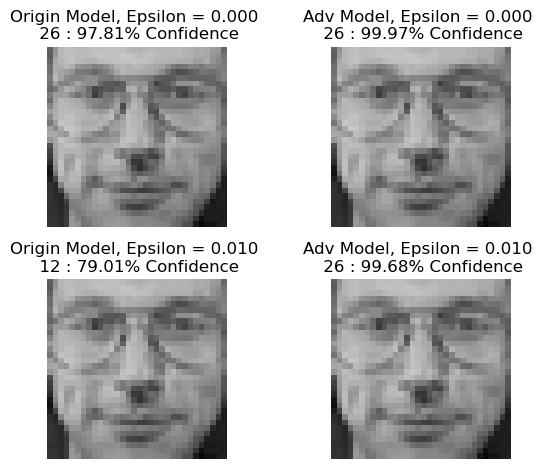

In [146]:
model.eval()
model_adv.eval()
adv_x1 = FGSM(model, x_test, y_test)
adv_x2 = FGSM(model_adv, x_test, y_test)

for i in range(x_test.shape[0]):
    img = x_test[i:i+1]
    label = y_test[i:i+1]
    if(torch.argmax(model(img), -1)[0] == label):
        adv_x = [adv_x1[i:i+1], adv_x2[i:i+1]]
        if(torch.argmax(model(img), -1)[0] != torch.argmax(model(adv_x[0]), -1)[0]):
            if(torch.argmax(model_adv(img), -1)[0] == torch.argmax(model_adv(adv_x[1]), -1)[0]):
                print("True Label : {}".format(label.item()))
                display_images(img, adv_x, model, model_adv)
                break
